In [1]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
spark

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import re
import matplotlib.pyplot as plt
# import tensorflow as tf
# import cv2

I will use the functionality of Image Datasource of spark to collect and process images in bytes, and then start processing the images for the neural network

In [4]:
images_folders = ['/CA1/Images/BakedPotato/','/CA1/Images/Pizza/','/CA1/Images/Taco/']

In [5]:
images_rdd = spark.sparkContext.binaryFiles(','.join(images_folders))
# images_rdd = spark.sparkContext.binaryFiles('hdfs://172.24.144.178:9000/CA1/Images/Ireland/Ireland_001.jpeg')

In [6]:
images_rdd

org.apache.spark.api.java.JavaPairRDD@2cdd77a3

In [7]:
def extract_data(data):
    file_path, image_data = data
#     image = Image.open(BytesIO(image_data))
#     image_array = np.array(image)
    
    file_name = file_path.split('/')[-1]
    file_name_without_ext = file_name.split(".")[0]
    label,name = file_name_without_ext.split('_')[0], file_name_without_ext.split('_')[1]
    
    return name, label, image_data

In [8]:
imageDf = images_rdd.map(lambda x: extract_data(x)).toDF(["Name","Label","Data"])

In [9]:
pandasImagesDF = imageDf.toPandas()

In [10]:
IMG_SHAPE=225

In [11]:
def processImage(data, target_size=(IMG_SHAPE,IMG_SHAPE)):
    imgbytes = BytesIO(data)
    image = Image.open(imgbytes)
    resized_img = image.resize(target_size, Image.ANTIALIAS)
    with BytesIO() as output:
        resized_img.save(output, format="PNG")
        new_image = Image.open(output)

        array = np.asarray(new_image).reshape([target_size[0],target_size[1],3])
        return array

In [12]:
pandasImagesDF["Data"] = pandasImagesDF["Data"].apply(lambda x: processImage(x))

In [13]:
# pandasImagesDF

In [14]:
pandasImagesDF = pandasImagesDF.sort_values(by=["Name"])

In [15]:
pandasImagesDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 0 to 874
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    875 non-null    object
 1   Label   875 non-null    object
 2   Data    875 non-null    object
dtypes: object(3)
memory usage: 27.3+ KB


In [16]:
NCATEGORIES = len(pandasImagesDF["Label"].unique())

In [17]:
NCATEGORIES

3

Importing from Keras functionality necessary to implement CNN

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, Input, MaxPool2D
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import RandomContrast, RandomBrightness, RandomRotation, RandomFlip

2024-03-26 23:13:15.525645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 23:13:16.539532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-03-26 23:13:18.348839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:18.561318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:18.561368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Now we are to split the data using train_test_split function to use Kfold and improve the perfomance of the model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pandasImagesDF["Data"],pandasImagesDF["Label"],test_size=0.2, random_state=42)

In [21]:
encoder = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)

In [22]:
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [23]:
X_train.shape

(700, 225, 225, 3)

In [24]:
X_train = np.reshape(X_train,(X_train.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)
X_test = np.reshape(X_test,(X_test.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)

Because the pixels are from 0 to 255, We have to normalize the pixels

In [25]:
X_train/=255
X_test/=255

In [26]:
X_train.shape,X_test.shape

((700, 225, 225, 3), (175, 225, 225, 3))

In [27]:
y_train.shape, y_test.shape

((700, 3), (175, 3))

In [28]:
model = Sequential(name="BareCNN")
model.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(3))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(NCATEGORIES,activation="softmax"))

model.compile(loss=tf.losses.categorical_crossentropy, metrics=["accuracy"], optimizer="adam")
model.summary()

2024-03-26 23:13:18.948110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:18.948259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:18.948304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:19.106002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 23:13:19.106082: I external/local_xla/xla/stream_executor

Model: "BareCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 221, 221, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,035,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,064,867 (38.39 MB)

 Trainable params: 10,064,867 (38.39 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train, batch_size=20, epochs=13, verbose=1, validation_data=(X_test, y_test))

Epoch 1/13


2024-03-26 23:13:19.574691: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 425250000 exceeds 10% of free system memory.
2024-03-26 23:13:19.849649: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 425250000 exceeds 10% of free system memory.
I0000 00:00:1711494801.061221   52066 service.cc:145] XLA service 0x7fe86400cb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711494801.061287   52066 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2024-03-26 23:13:21.131410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 23:13:21.347278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-26 23:13:27.403321: E external/local_xla/xla/service/slow_operation_alarm.cc

 3/35 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3472 - loss: 4.4460

I0000 00:00:1711494811.598157   52066 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.3258 - loss: 2.3250 - val_accuracy: 0.3657 - val_loss: 1.0939
Epoch 2/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3591 - loss: 1.0908 - val_accuracy: 0.5029 - val_loss: 0.9894
Epoch 3/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4471 - loss: 1.0266 - val_accuracy: 0.5143 - val_loss: 1.0002
Epoch 4/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6709 - loss: 0.8295 - val_accuracy: 0.5714 - val_loss: 0.8922
Epoch 5/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7156 - loss: 0.6620 - val_accuracy: 0.6171 - val_loss: 0.9299
Epoch 6/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8241 - loss: 0.4578 - val_accuracy: 0.6000 - val_loss: 0.9105
Epoch 7/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8343 - loss: 0.4374 - val_accuracy: 0.6343 - val_loss: 1.1194
Epoch 8/13
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9264 - loss: 0.2125 - val_accuracy: 0.6229 - val_loss: 

6/6 - 3s - 523ms/step - accuracy: 0.5543 - loss: 1.8740


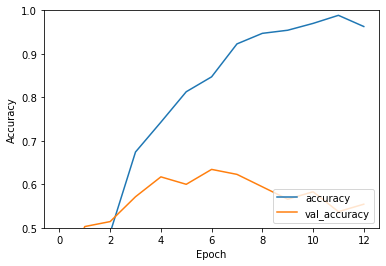

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

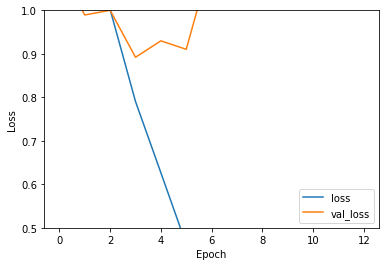

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [32]:
print(test_acc)

0.5542857050895691


### Trying Data Augmentation 

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
dataAugmented = Sequential()
# dataAugmented.add(RandomContrast(0.7))
# dataAugmented.add(RandomBrightness(0.7))
dataAugmented.add(RandomRotation(0.4))
dataAugmented.add(RandomFlip("horizontal_and_vertical"))


In [100]:
modelAugmented = Sequential()
modelAugmented.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
modelAugmented.add(dataAugmented)
modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
modelAugmented.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
modelAugmented.add(MaxPool2D(3))

modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
modelAugmented.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
# modelAugmented.add(MaxPool2D(3))

modelAugmented.add(Flatten())
modelAugmented.add(Dense(256, activation="relu"))
modelAugmented.add(Dropout(0.25))
modelAugmented.add(Dense(NCATEGORIES,activation="softmax"))

modelAugmented.compile(loss=tf.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
modelAugmented.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 223, 223, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 221, 221, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 69, 69, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 152352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    39,002,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,060,355 (149.00 MB)

 Trainable params: 39,060,355 (149.00 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((700, 225, 225, 3), (175, 225, 225, 3), (700, 3), (175, 3))

In [102]:
history = modelAugmented.fit(X_train, y_train, batch_size=12, epochs=40, verbose=1, validation_data=(X_test, y_test))

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.3650 - loss: 1.1042 - val_accuracy: 0.5257 - val_loss: 0.9804
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4819 - loss: 0.9625 - val_accuracy: 0.5714 - val_loss: 0.8850
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6414 - loss: 0.8261 - val_accuracy: 0.5657 - val_loss: 0.8917
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6277 - loss: 0.7771 - val_accuracy: 0.6057 - val_loss: 0.7935
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6971 - loss: 0.7115 - val_accuracy: 0.6514 - val_loss: 0.7497
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.6894 - loss: 0.7292 - val_accuracy: 0.6286 - val_loss: 0.7847
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6861 - loss: 0.6840 - val_accuracy: 0.6057 - val_loss: 0.8143
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7264 - loss: 0.6594 - val_accuracy: 0.6114 - v

In [103]:
# pred = modelAugmented.predict(X_test[:25])

In [104]:
# comparePredictions(np.argmax(pred, axis=1),np.argmax(y_test[:25], axis=1))

6/6 - 1s - 111ms/step - accuracy: 0.6629 - loss: 0.7886


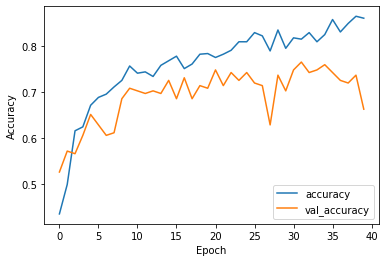

In [112]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelAugmented.evaluate(X_test,  y_test, verbose=2)

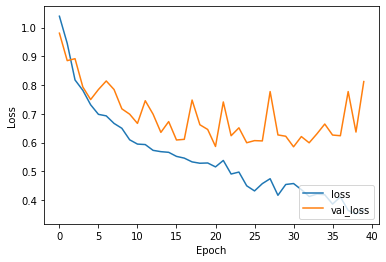

In [111]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [110]:
print(test_acc)

0.6628571152687073


In [118]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [114]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [128]:
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classifier on top
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
output = Dense(NCATEGORIES, activation='softmax')(x)

In [129]:
modelVGG = Model(inputs=vgg_base.input, outputs=output)
modelVGG.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
modelVGG.summary()

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 225, 225, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 225, 225, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [130]:
history = modelVGG.fit(X_train, y_train, batch_size=12, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4867 - loss: 3.4422 - val_accuracy: 0.7657 - val_loss: 0.5439
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9328 - loss: 0.2139 - val_accuracy: 0.8114 - val_loss: 0.5111
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9965 - loss: 0.0476 - val_accuracy: 0.8400 - val_loss: 0.4902
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.8229 - val_loss: 0.5339
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.8171 - val_loss: 0.5258
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8286 - val_loss: 0.5277
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.8057 - val_loss: 0.5736
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8114 - v

6/6 - 1s - 192ms/step - accuracy: 0.8286 - loss: 0.5925


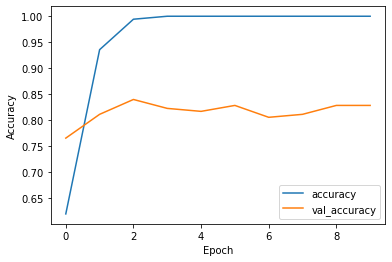

In [131]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelVGG.evaluate(X_test,  y_test, verbose=2)

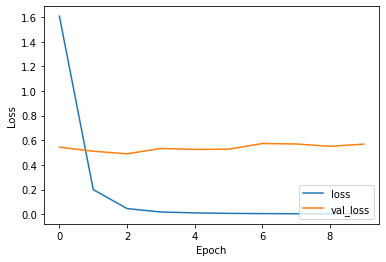

In [132]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [133]:
print(test_acc)

0.8285714387893677


## Using Hyperparameter tuning

In [43]:
pip install scikeras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [44]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [45]:
def create_model(dropout_rate=0.25, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
    model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(MaxPool2D(3))
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
    model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(NCATEGORIES, activation="softmax"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [46]:
keras_model = KerasClassifier(build_fn=create_model, verbose=1)

In [47]:
param_grid = {
    'model__dropout_rate': [0.25, 0.5],
    'model__learning_rate': [0.001, 0.0001]
}

In [48]:
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, verbose=1)


In [49]:
tf.config.experimental.list_physical_devices('CPU')


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [50]:
# # Perform the grid search
# with tf.device('/CPU:0'):
#     grid_result = grid.fit(X_train, y_train)  # Assuming X_train and y_train are your training data
